In [1]:
import cvxpy as cp
from patsy import dmatrix
from nldg.utils import *
from nldg.splines import *

In [132]:
data_setting = 3
if data_setting == 1:
    dtr = gen_data_v2(n=1000)
elif data_setting == 2:
    dtr = gen_data_v3(n=1000, setting=2)
elif data_setting == 3:
    dtr = gen_data_v4(n_easy=1000, n_hard=1000)
elif data_setting == 4:
    dtr = gen_data_v5(n_samples=1000, adv_fraction=0.5, noise_var_env2=10.0)
else:
    dtr = gen_data_v6(n=1000, noise_std=0.5)
Xtr = np.array(dtr.drop(columns=['E', 'Y']))
Ytr = np.array(dtr['Y'])
Ytr = Ytr - np.mean(Ytr)
dtr['Y'] = Ytr
Etr = np.array(dtr['E'])

## CVXPY

In [133]:
x_min = dtr["X"].min()
x_max = dtr["X"].max()

degree = 3  # cubic splines
n_bases = 10  # number of basis functions

n_internal = n_bases - degree + 1  # number of internal knots
internal_knots = np.linspace(x_min, x_max, n_internal)
knots = np.concatenate((np.repeat(x_min, degree),
                        internal_knots,
                        np.repeat(x_max, degree)))
M = len(knots) - degree - 1

# Compute the penalty matrix using a fine grid over the domain.
grid = np.linspace(x_min, x_max, 400)
Omega = omega(knots, degree, grid)

N = bspline_N(Xtr, knots, degree)
Y_pooled = Ytr

_lambda = 0.01

# Classical solution
beta = cp.Variable(M)
objective = cp.Minimize(
    cp.mean(cp.square(Y_pooled - N @ beta)) +
    _lambda * cp.quad_form(beta, Omega)
)
problem = cp.Problem(objective)
problem.solve(solver=cp.SCS)

# Maximin
mask_env0 = (Etr == 0)
mask_env1 = (Etr == 1)

N0 = bspline_N(Xtr[mask_env0], knots, degree)
N1 = bspline_N(Xtr[mask_env1], knots, degree)

Y_env0 = Ytr[mask_env0]
Y_env1 = Ytr[mask_env1]

beta_maximin = cp.Variable(M)
t = cp.Variable(nonneg=True)

constraints = []
constraints.append(cp.mean(cp.square(Y_env0 - N0 @ beta_maximin)) <= t)
constraints.append(cp.mean(cp.square(Y_env1 - N1 @ beta_maximin))<= t)

if data_setting in [2, 5]:
    mask_env2 = (Etr == 2)
    N2 = bspline_N(Xtr[mask_env2], knots, degree)
    Y_env2 = Ytr[mask_env2]
    constraints.append(cp.mean(cp.square(Y_env2 - N2 @ beta_maximin)) <= t)

objective_maximin = cp.Minimize(
    t + _lambda * cp.quad_form(beta_maximin, Omega)
)
problem_maximin = cp.Problem(objective_maximin, constraints)
problem_maximin.solve()

# Predictions
x_grid = np.linspace(x_min, x_max, 200)
X_grid = bspline_N(x_grid, knots, degree)

preds_erm = X_grid @ beta.value
preds_maximin = X_grid @ beta_maximin.value

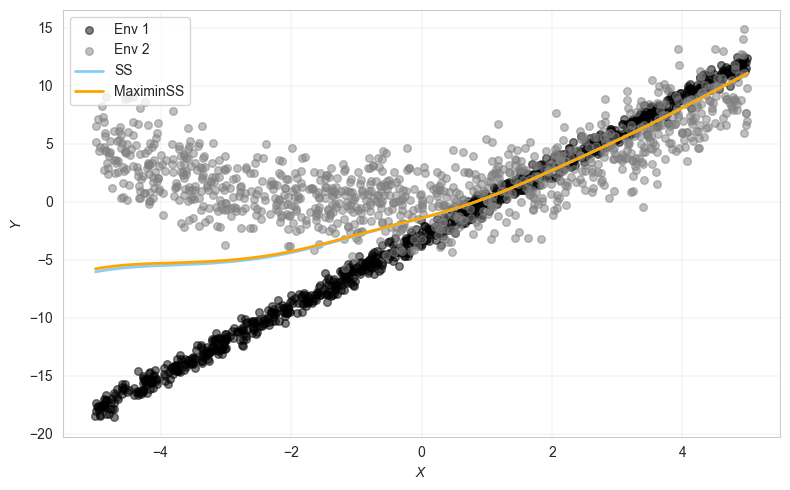

In [134]:
plot_dtr(dtr, x_grid, preds_erm, preds_maximin)

In [135]:
fitted = N @ beta.value
max_mse(Ytr, fitted, Etr, verbose=True)

Environment 0 MSE: 22.001982961737472
Environment 1 MSE: 23.889622948230944


np.float64(23.889622948230944)

In [136]:
fitted_maximin = N @ beta_maximin.value
max_mse(Ytr, fitted_maximin, Etr, verbose=True)

Environment 0 MSE: 22.956196415334983
Environment 1 MSE: 22.956196729066033


np.float64(22.956196729066033)

## GDRO algorithm

In [137]:
if data_setting in [2, 5]:
    N_envs = [torch.tensor(N0, dtype=torch.float32),
              torch.tensor(N1, dtype=torch.float32),
              torch.tensor(N2, dtype=torch.float32),]
    Y_envs=[torch.tensor(Y_env0, dtype=torch.float32),
            torch.tensor(Y_env1, dtype=torch.float32),
            torch.tensor(Y_env2, dtype=torch.float32),]
else:
    N_envs=[torch.tensor(N0, dtype=torch.float32),
             torch.tensor(N1, dtype=torch.float32),]
    Y_envs=[torch.tensor(Y_env0, dtype=torch.float32),
            torch.tensor(Y_env1, dtype=torch.float32),]

beta_hat, env_weights = train_spline_GDRO(
     N_envs=N_envs,
     Y_envs=Y_envs,
     Omega=torch.tensor(Omega, dtype=torch.float32),
     lr_beta=0.2,
     eta=0.1,
     lambda_reg=0.01,
     epochs=1000,
     verbose=True
)

Early stopping at epoch 66


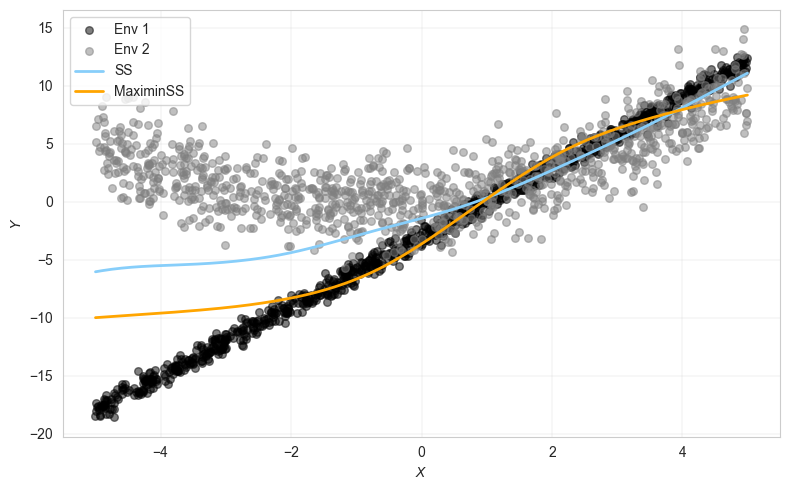

In [138]:
preds_gdro = X_grid @ beta_hat

plot_dtr(dtr, x_grid, preds_erm, preds_gdro)

In [139]:
fitted_gdro = N @ beta_hat
max_mse(Ytr, fitted_gdro, Etr, verbose=True)

Environment 0 MSE: 6.7905541247006225
Environment 1 MSE: 54.566110477812806


np.float64(54.566110477812806)

## Extragradient

In [140]:
beta_hat, p_hat = train_spline_extragradient(
    N_envs=N_envs,
    Y_envs=Y_envs,
    Omega=torch.tensor(Omega, dtype=torch.float32),
    alpha=0.01,
    lambda_reg=0.01,
    epochs=3000,
    verbose=True
)

Iter 0/3000: obj=67.552734
Iter 300/3000: obj=32.263168
Iter 600/3000: obj=26.177107
Iter 900/3000: obj=24.948933
Iter 1200/3000: obj=24.098562
Iter 1500/3000: obj=23.726755
Iter 1800/3000: obj=23.448814
Iter 2100/3000: obj=23.295921
Iter 2400/3000: obj=23.188732
Iter 2700/3000: obj=23.121574


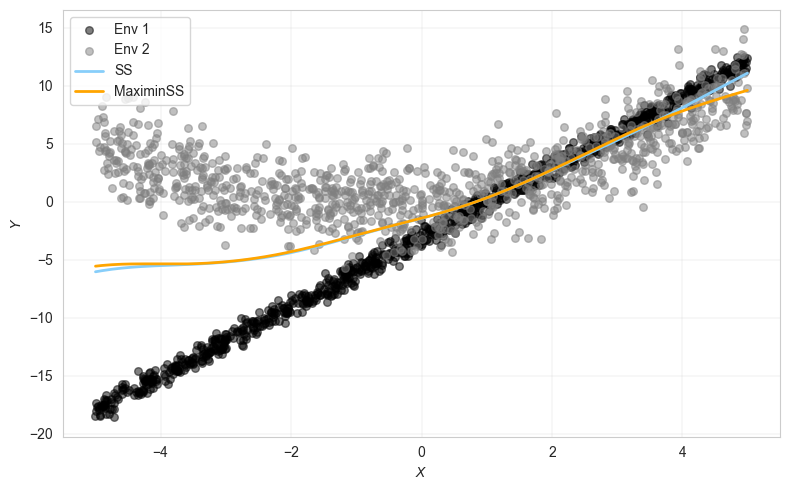

In [141]:
preds_extragradient = X_grid @ beta_hat

plot_dtr(dtr, x_grid, preds_erm, preds_extragradient)

In [142]:
fitted_extragradient = N @ beta_hat
max_mse(Ytr, fitted_extragradient, Etr, verbose=True)

Environment 0 MSE: 23.063528704865412
Environment 1 MSE: 23.02744606652628


np.float64(23.063528704865412)

## GDRO online

In [143]:
beta_hat, q = train_spline_online_GDRO(
     N_envs=N_envs,
     Y_envs=Y_envs,
     Omega=torch.tensor(Omega, dtype=torch.float32),
     eta=0.1,
     eta_theta=0.1,
     lambda_reg=0.01,
     T=1500,
     verbose=True
)

Iter 150/1500: sampled g=0, q_max_idx=0, loss=28.9393, theta_norm=20.4997
Iter 300/1500: sampled g=0, q_max_idx=0, loss=0.0006, theta_norm=26.9660
Iter 450/1500: sampled g=0, q_max_idx=0, loss=0.2976, theta_norm=30.7061
Iter 600/1500: sampled g=0, q_max_idx=0, loss=0.0840, theta_norm=32.9381
Iter 750/1500: sampled g=0, q_max_idx=0, loss=0.1944, theta_norm=34.1226
Iter 900/1500: sampled g=0, q_max_idx=0, loss=0.0856, theta_norm=34.5474
Iter 1050/1500: sampled g=0, q_max_idx=0, loss=0.0137, theta_norm=34.8568
Iter 1200/1500: sampled g=1, q_max_idx=0, loss=9.8872, theta_norm=34.7271
Iter 1350/1500: sampled g=1, q_max_idx=0, loss=190.0138, theta_norm=34.8262
Iter 1500/1500: sampled g=1, q_max_idx=0, loss=1.6901, theta_norm=34.7212


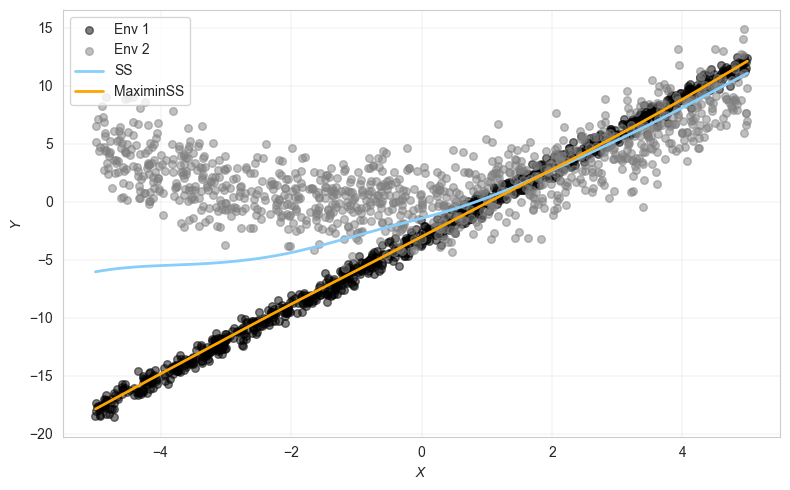

In [144]:
preds_gdro_online = X_grid @ beta_hat

plot_dtr(dtr, x_grid, preds_erm, preds_gdro_online)

In [145]:
fitted_gdro_online = N @ beta_hat
max_mse(Ytr, fitted_gdro_online, Etr, verbose=True)

Environment 0 MSE: 0.2895367937935707
Environment 1 MSE: 89.47467969754874


np.float64(89.47467969754874)

## Subgradient method

In [146]:
beta_hat, worst_loss_hist = train_spline_subgradient(
     N_envs=N_envs,
     Y_envs=Y_envs,
     Omega=torch.tensor(Omega, dtype=torch.float32),
     lr=0.1,
     lambda_reg=0.01,
     epochs=1500,
     verbose=True
)

iter  150  env*=0  MSE*=2.4142e+01  obj≈2.4207e+01
iter  300  env*=1  MSE*=2.3470e+01  obj≈2.3501e+01
iter  450  env*=0  MSE*=2.3647e+01  obj≈2.3670e+01
iter  600  env*=1  MSE*=2.2962e+01  obj≈2.2986e+01
iter  750  env*=0  MSE*=2.3590e+01  obj≈2.3614e+01
iter  900  env*=1  MSE*=2.3132e+01  obj≈2.3156e+01
iter 1050  env*=0  MSE*=2.3364e+01  obj≈2.3387e+01
iter 1200  env*=1  MSE*=2.3334e+01  obj≈2.3359e+01
iter 1350  env*=0  MSE*=2.3179e+01  obj≈2.3202e+01
iter 1500  env*=1  MSE*=2.3493e+01  obj≈2.3517e+01


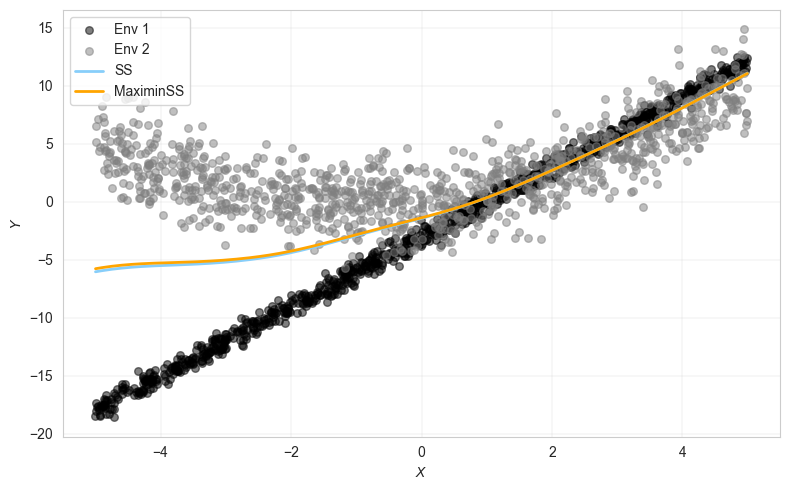

In [147]:
preds_subgradient = X_grid @ beta_hat

plot_dtr(dtr, x_grid, preds_erm, preds_subgradient)

In [148]:
fitted_subgradient = N @ beta_hat
max_mse(Ytr, fitted_subgradient, Etr, verbose=True)

Environment 0 MSE: 23.09610074315114
Environment 1 MSE: 22.82209480525242


np.float64(23.09610074315114)